To see the videos (and nicer math rendering) please open this notebook in Google Colab:
<a href="https://colab.research.google.com/github/richard-warren/rl_sandbox/blob/master/ilqr_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# iLQR - in principle

## overview
In **optimal control** we seek to control a system such that some cost function is minimized. [Some consider this an attractive model for biological motor control](https://homes.cs.washington.edu/~todorov/papers/TodorovNatNeurosci02.pdf) because it helps resolve difficulties associated with the redundancy of biomechanical systems. There can be infinitely many ways to accomplish a control objective (e.g. reaching to a target); by casting this as an optimization problem we can "simply" minimize some cost function (e.g. distance to target). This framework predicts that variability will persist along dimensions irrelevant to the cost function, a prediction [that has some experimental support](https://homes.cs.washington.edu/~todorov/papers/TodorovNatNeurosci02.pdf).

For simple systems with linear dynamics and quadratic cost functions there exist well-studied methods for finding (provably) optimal control strategies. [LQR](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator) finds a feedback matrix $\mathbf{K}$ that linearly maps the state of the system to control inputs that are optimal with respect to the cost function (although this is only possible when the system is ["controllable!"](https://www.youtube.com/watch?v=u5Sv7YKAkt4)). Hope is not lost when the dynamics and cost function aren't linear and quadratic. We can use Taylor expansion to find first and second order approximations of the dynamics and cost, then apply LQR methods (albeit without the same theoretical guarantees).

[iLQR](https://homes.cs.washington.edu/~todorov/papers/LiICINCO04.pdf) is an iterative version of LQR (and a slightly simplified version of [Differential Dynamic Programming](https://en.wikipedia.org/wiki/Differential_dynamic_programming)). LQR finds a single feedback rule that linearly maps states to actions; this rule could be defined using an approximation of the dynamics around a single point. But if we stray too far from that point the approximation may fail. In iLQR we iteratively optimize control inputs for *entire trajectories*, defining feedback (and feed-forward) control laws for each time step in the trajectory. Regularization is used to ensure we don't stray too far from the points around which the approximations are made. iLQR can find really impressive behaviors for finite-horizon problems, and can be used for [online trajectory optimization](https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf) if controls are optimized at each timestep for some finite horizon.

## derivation
Consider a discrete-time, finite-horizon, deterministic system described at each time $i$ by a state $\mathbf{x}_i$. The system evolves (potentially non-linearly) according to the previous state and action $\mathbf{u}$ (I will use the terms "action" and "control input" interchangeably):

$$
\begin{align*}
\mathbf{x}_{i+1} = \mathbf{f}(\mathbf{x}_i, \mathbf{u}_i)
\end{align*}
$$

Notice that trajectories evolve according to the sequence of actions $U \equiv { \mathbf{u}_0, \mathbf{u}_1, \dots \mathbf{u}_N}$ and the *initial state*. All subsequent states ${ \mathbf{x}_1, \mathbf{x}_2, \dots \mathbf{x}_N}$ unravel deterministically based on the initial state and the control sequence.

Our goal is to maximize the "goodness" (minimize the "badness") of the trajectory. The badness of a trajectory is defined by a cost function of the form:

$$ J_0(\mathbf{x}_0, \mathbf{U}) = \sum_{i=0}^{N-1} \ell(\mathbf{x}_i, \mathbf{u}_i) + \ell_f(\mathbf{x}_N) $$

Notice there are different costs $\ell_f$ and $\ell$ for the final step and all preceding steps. Whereas the cost of the final step is only affected by the state (e.g. the distance of an end effector to a target), the other steps are affected by the state and the control inputs $\mathbf{u}$. This allows us to find efficient policies that penalize excessive control expenditure.

We want to find the control sequence $\mathbf{U}$ that minimizes the cost $J$. To do this we rely on the [principle of optimality](https://en.wikipedia.org/wiki/Bellman_equation#:~:text=Principle%20of%20Optimality%3A%20An%20optimal,See%20Bellman%2C%201957%2C%20Chap.); at each time we pick the action that minimizes the immediate cost plus the sum of future costs, *assuming we behave optimally for subsequent steps*. We will (somewhat confusingly) define the **value** of a state at time $i$ (notice that the value of a state depends on the time!) to be the cost we expect if $\mathbf{U}$ is optimal. Here $J_i$ means we are only considering times from $i \rightarrow N$:

$$
\begin{align*}
V_i(\mathbf{x})
&= \min_{\mathbf{U}} J_i(\mathbf{x}, \mathbf{U}) \nonumber \\
&= \min_{\mathbf{u}} [\ell(\mathbf{x}, \mathbf{u}) + V_{i+1}(\mathbf{x_{i+1}})] \nonumber \\
&= \min_{\mathbf{u}} [\ell(\mathbf{x}, \mathbf{u}) + V_{i+1}(\mathbf{f}(\mathbf{x}, \mathbf{u}))] \tag{1}
\end{align*}
$$

Remember that the value is *only a function of the state* (because we assume optimal actions). This means that given the current state $\mathbf{x}$, we just need to pick the current best $\mathbf{u}$, which together determine both the immediate loss and the value at the next state. Now we can reason about the optimality of trajectories by sequentially reasoning about the optimality of individual steps. Nice.

So far so good, but how do we pick the best $\mathbf{u}$ at each time. Imagine we start with an initial action sequence $\mathbf{U}$ which determines (together with the initial state) a sequence of states. Now, positioning ourselves at some time $i$ within that trajectory, we are going to build a quadratic approximation of the argument to $(1)$ as a function of $\mathbf{x}$ and $\mathbf{u}$. This approximation is centered around our current $\mathbf{x}_i$, $\mathbf{u}_i$. $V'$ here denotes the value of the subsequent state.

$$
\begin{align*}
Q(\mathbf{x}, \mathbf{u})
&= &&\ell(\mathbf{x},\mathbf{u}) + V'(\mathbf{f}(\mathbf{x},\mathbf{u})) \tag{2} \\
&\approx && Q(\mathbf{x}_i,\mathbf{u}_i) + Q_{\mathbf{x}}(\mathbf{x}_i,\mathbf{u}_i)^\intercal (\mathbf{x}-\mathbf{x}_i) \\
&&&+ Q_{\mathbf{u}}(\mathbf{x}_i,\mathbf{u}_i)^\intercal(\mathbf{u}-\mathbf{u}_i) + \frac{1}{2} (\mathbf{x}-\mathbf{x}_i)^\intercal Q_{\mathbf{xx}}(\mathbf{x}_i,\mathbf{u}_i)(\mathbf{x}-\mathbf{x}_i) \\
&&&+ (\mathbf{u}-\mathbf{u}_i)^\intercal Q_{\mathbf{ux}}(\mathbf{x}_i,\mathbf{u}_i)(\mathbf{x}-\mathbf{x}_i) + \frac{1}{2} (\mathbf{u}-\mathbf{u}_i)^\intercal Q_{\mathbf{uu}}(\mathbf{x}_i,\mathbf{u}_i)(\mathbf{u}-\mathbf{u}_i)
\end{align*}
$$

We'll clean things up by setting $\mathbf{\delta u}=(\mathbf{u}-\mathbf{u}_i)$, $\mathbf{\delta x}=(\mathbf{x}-\mathbf{x}_i)$, and dropping the $(\mathbf{x}_i,\mathbf{u}_i)$ dependencies. Now our function describes how the value *changes* as we nudge $\mathbf{x}$ and $\mathbf{u}$ around.

$$
\begin{align*}
Q(\mathbf{\delta x}, \mathbf{\delta u})
&\approx Q + Q_{\mathbf{x}}^\intercal \mathbf{\delta x} + Q_{\mathbf{u}}^\intercal \mathbf{\delta u} + \frac{1}{2} \mathbf{\delta x}^\intercal Q_{\mathbf{xx}}\mathbf{\delta x} + \mathbf{\delta u}^\intercal Q_{\mathbf{ux}}\mathbf{\delta x} + \frac{1}{2}\mathbf{\delta u}^\intercal Q_{\mathbf{uu}}\mathbf{\delta u}
\end{align*} \tag{3}
$$

We want to find the $\mathbf{\delta u}$ that is the best possible adjustment to our control input, i.e. the one that minimizes the value function. Taking advantage of the fact that this is a quadratic approximation (which has a single extremum), we differentiate $(3)$ w.r.t. $\mathbf{\delta u}$ and set it equal to 0. Keep in mind that all the $Q$ terms are constant.

$$
\begin{align*}
\frac{\mathbf{\delta Q}}{\mathbf{\delta u}} &= 0 \\
Q_{\mathbf{u}} + Q_{\mathbf{ux}}\mathbf{\delta x} + Q_{\mathbf{uu}}\mathbf{\delta u} &= 0 \\
\mathbf{\delta u} &= -Q_{\mathbf{uu}}^{-1}(Q_{\mathbf{u}} + Q_{\mathbf{ux}}\mathbf{\delta x}) \tag{4}
\end{align*}
$$

Cool. Distributing $Q_{\mathbf{uu}}^{-1}$ gives us feed-forward and feedback terms $\mathbf{k}$ and $\mathbf{K}$ with which we can update our previous action $\mathbf{u}$ to $\hat{\mathbf{u}}$:

$$
\begin{align*}
\mathbf{k} &= -Q_{\mathbf{uu}}^{-1} Q_{\mathbf{u}} \\
\mathbf{K} &= -Q_{\mathbf{uu}}^{-1} Q_{\mathbf{ux}} \\
\hat{\mathbf{u}} &= \mathbf{u} + \mathbf{k} + \mathbf{K \delta x}
\end{align*}
$$

Notice that our update depends on $\mathbf{\delta x}$. Although the intitial state will be the same for all iterations of the optimization, updates in the control sequence will cause differences to emerge between states at the same time step on successive iterations. $\mathbf{K}$ acts on these $\mathbf{\delta x}$'s to keep things in line. We need to keep an eye on this; if we update $\mathbf{U}$ too aggressively we might stray from the region where our quadratic approximation is valid. Regularization will help on this front (see below).

Now we'll compute the coefficients for the quadratic expansion $(3)$. Using the product and chain rules we can differentiate $(2)$ to obtain:

$$
\begin{align*}
Q_{\mathbf{x}}  &= \ell_{\mathbf{x}} + \mathbf{f}_{\mathbf{x}}^\intercal V'_{\mathbf{x}} \\
Q_{\mathbf{u}}  &= \ell_{\mathbf{u}} + \mathbf{f}_{\mathbf{u}}^\intercal V'_{\mathbf{x}}\\
Q_{\mathbf{xx}} &= \ell_{\mathbf{xx}} + \mathbf{f}_{\mathbf{x}}^\intercal V'_{\mathbf{xx}}\mathbf{f}_{\mathbf{x}} + V'_{\mathbf{x}}\mathbf{f}_{\mathbf{xx}} \\
Q_{\mathbf{uu}} &= \ell_{\mathbf{uu}} + \mathbf{f}_{\mathbf{u}}^\intercal V'_{\mathbf{xx}}\mathbf{f}_{\mathbf{u}} + V'_{\mathbf{x}}\mathbf{f}_{\mathbf{uu}} \\
Q_{\mathbf{ux}} &= \ell_{\mathbf{xu}} + \mathbf{f}_{\mathbf{u}}^\intercal V'_{\mathbf{xx}}\mathbf{f}_{\mathbf{x}} + V'_{\mathbf{x}}\mathbf{f}_{\mathbf{ux}}
\end{align*}
$$

iLQR ignores the second derivatives of $\mathbf{f}$ (the final terms in lines 3-5 above), which will speed things up a lot when using finite differences for derivative calculations. Differential dynamic programming uses all the terms.

Importantly, computing $Q$ at a given time requires knowing $V$ at the subsequent time. We will therefore work backwards from the final state, relying on the fact that $V_{\mathbf{x}}$ and $V_{\mathbf{xx}}$ can be easily computed for the final state. But how do we find the $V$ terms? Plugging $(4)$ into $(3)$ we get the following quadratic model of $V$. Recall that $V$ assumes optimal behavior, which is why it incorporates the optimal $\mathbf{\delta u}$ we derived above.

$$
\begin{align*}
\bigtriangleup V &= -\frac{1}{2} Q_\mathbf{u}^\intercal Q_\mathbf{uu}^{-1}Q_\mathbf{u} \\
V_\mathbf{x} &= Q_\mathbf{x} - \frac{1}{2} Q_\mathbf{u}^\intercal Q_\mathbf{uu}^{-1}Q_\mathbf{ux} \\
V_\mathbf{xx} &= Q_\mathbf{xx} - \frac{1}{2} Q_\mathbf{xu}^\intercal Q_\mathbf{uu}^{-1}Q_\mathbf{ux}
\end{align*}
$$

$\bigtriangleup V$ is the change in the value we should expect *if our quadratic approximation is accurate*. This is nice, because we can compare the expected and actual cost reduction during the optimization and use it to guide our regularization strategy. The (whiteboard) proof for the above equations is below. The trick is to set $\mathbf{\delta x}=\mathbf{\delta u}=0$ at the end, because this is the point around which our quadratic model is constructed:

![](ilqr/V_proof.jpg)

## regularization
The control modification $(4)$ uses information about the curvature of $Q$ stored in $Q_\mathbf{uu}$. However, if $Q_\mathbf{uu}$ is non-positive definite then the update may not be in a [descent direction](https://en.wikipedia.org/wiki/Descent_direction). We will therefore regularize $Q_\mathbf{uu}$ by adding to its diagonal entries:

$$ \tilde{Q}_\mathbf{uu} = Q_\mathbf{uu} + \mu \mathbf{I} $$


The regularization parameter $\mu$ will depend on how the optimization is going. When the cost is decreasing we will decrease regularization, and when the cost in increasing (or when $Q_\mathbf{uu}$ is non-PD) we will increase regularization (this is the [Levenberg-Marquardt heuristic](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm#Choice_of_damping_parameter)). The regularization term effectively interpolates between Gauss-Newton optimization - which uses curvature information - and gradient descent. To see this we can rewrite $(4)$ using $\tilde{Q}_\mathbf{uu}$ instead of $Q_\mathbf{uu}$:

$$  -(Q_\mathbf{uu} + \mu \mathbf{I}) \mathbf{\delta u} = Q_{\mathbf{u}} + Q_{\mathbf{ux}}\mathbf{\delta x} $$

As $\mu$ is increased, the feed-forward component of $\mathbf{\delta u}$ is in the opposite direction of the gradient. Importantly, using $\tilde{Q}_\mathbf{uu}$ affects the formulae for $V$; more accurate versions of these formulae can be found [here (equations 11)](https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf). These updated formulae are used in the experiments below.

## algorithm
Putting everything together, we are left with the following algorithm:
1. **Compute derivatives** for states and costs along the current trajectory ($\ell_\mathbf{x}, \ell_\mathbf{u}, \ell_\mathbf{xx}, \ell_\mathbf{ux}, \ell_\mathbf{uu}, \mathbf{f_x}, \mathbf{f_u}$). We will need them to compute $Q$ and $V$ in the next step.
2. **Work backwards** from the final time step, at each step computing the control modifications $\mathbf{k}$, $\mathbf{K}$, in addition to $V_\mathbf{x}, V_\mathbf{xx}$.
3. **Compute a new trajectory** using the modified control law. If the cost decreases, keep the new control sequence and decrease regularization; otherwise increase regularization and try the backward pass again.

# iLQR - in practice

I implemented iLQR as described in [this paper](https://homes.cs.washington.edu/~todorov/papers/TassaICRA14.pdf) (except for some differences described below). Yuval Tassa's [MATLAB code](https://www.mathworks.com/matlabcentral/fileexchange/52069-ilqg-ddp-trajectory-optimization) was a very useful reference. [This Python implementation](https://github.com/studywolf/control/blob/master/studywolf_control/controllers/ilqr.py) was also a useful reference, although it lacked some bells and whistles from the paper.

## implementation notes
- **Tasks:**  For fast troubleshooting I started with a custom point-mass implementation. I then solved a few tasks in the [`dm_control suite`](https://github.com/deepmind/dm_control): point-mass, reacher, and hopper.
I built wrappers for these evnironments, which allowed me to replace the reward functions with cost functions more amenable to iLQR.

- **Differentiation:** To make the algorithm applicable to complex cost functions and dynamics I computed all derivatives using [finite differences](https://github.com/richard-warren/rl_sandbox/blob/20b0512748516a1651c6cbe3d8d1cd013d9f1ee7/ilqr/envs.py#L87), although some derivatives could have been computed analytically for some tasks (e.g. point-mass).

- **Matrix inversion:** Solving for $Q_\mathbf{uu}^{-1}$ directly can be computationally expense. It is better to solve linear systems for $\mathbf{k}$ and $\mathbf{K}$, e.g. use `numpy.linalg.solve()` on $-Q_\mathbf{uu}\mathbf{k} = Q_\mathbf{u}$. Even better, we can first perform a [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) on $Q_\mathbf{uu}$, then solve two linear systems, as described in the notes [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html).

- **$\alpha$ line search:** The original paper uses an additional regularization parameter $\alpha$ that linearly interpolates between the full update and intermediate updates by scaling the feed-forward term: $\hat{\mathbf{u}} = \mathbf{u} + \alpha \mathbf{k} + \mathbf{K \delta x}$. They also use a clever scheme to update $\alpha$ based on the ratio between expected and observed cost reductions. I primarily used $\alpha$ as a fixed term and found that setting $\alpha<1$ was only helpful in limited settings. I'm sure this becomes important in more complex tasks.

- **Regularization schedule:** For updating the regularization parameter $\mu$ I used the quadratic modification schedule described in section II.F [here](https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf).

- **Control limits:** In the original paper Yuval handles control limits by framing the problem as one of box-constrained optimization. In the experiments below [I simply pass the actions through a sigmoid function](https://github.com/richard-warren/rl_sandbox/blob/20b0512748516a1651c6cbe3d8d1cd013d9f1ee7/ilqr/envs.py#L224) $2 / (1+e^{-4x}) - 1$, which limits actions to $(-1,1)$.

## point mass
We'll start with [a custom point-mass environment](https://github.com/richard-warren/rl_sandbox/blob/20b0512748516a1651c6cbe3d8d1cd013d9f1ee7/ilqr/envs.py#L104). The goal is to move a point-mass in a 2D plane from a constant starting position to a random target position by applying forces. First let's check out a rollout with random actions:

In [1]:
from ilqr.envs import PointMass, PointMassDm, Arm, Hopper
from ilqr.plot_utils import show_rollout, plot_training
import matplotlib.pyplot as plt
from ilqr.ilqr import iLQR
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.random.seed(0)

# show video with random actions
env = PointMass();
env.target = np.array((.2,.4));  # manually set target position for reproducibility
actions = [np.random.uniform([-.2,-.2], [.2,.2]) for i in range(100)]
show_rollout(env, actions)

Now let's use iLQR to find an optimal control sequence. The environment objects have methods for computing [state](https://github.com/richard-warren/rl_sandbox/blob/20b0512748516a1651c6cbe3d8d1cd013d9f1ee7/ilqr/envs.py#L43) and [cost](https://github.com/richard-warren/rl_sandbox/blob/20b0512748516a1651c6cbe3d8d1cd013d9f1ee7/ilqr/envs.py#L51) derivates via finite differences. [The iLQR function](https://github.com/richard-warren/rl_sandbox/blob/20b0512748516a1651c6cbe3d8d1cd013d9f1ee7/ilqr/ilqr.py#L6) uses these to iteratively improve a sequence of actions as described above.

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     1/10   2.916988    -1.71e+01   -1.72e+01   6.25e-01    decreased   0.392816    
     2/10   2.361495    -5.55e-01   -6.16e-01   2.44e-01    decreased   0.657600    
     3/10   2.082782    -2.79e-01   -3.29e-01   5.96e-02    decreased   0.932399    
     4/10   1.920584    -1.62e-01   -2.28e-01   9.09e-03    decreased   1.321497    
     5/10   1.878605    -4.20e-02   -1.21e-01   8.67e-04    decreased   1.844925    
     6/10   1.921676    +4.31e-02   -4.89e-02   1.39e-03    increased   1.844925    
     7/10   1.902709    +2.41e-02   -4.49e-02   3.55e-03    increased   1.844925    
     8/10   1.864629    -1.40e-02   -3.81e-02   2.22e-03    decreased   2.298624    
     9/10   1.842958    -2.17e-02   -2.20e-02   8.67e-04    decreased   2.047202    
    10/10   1.838933    -4.03e-03   -4.29e-03   2.12e-04    decr

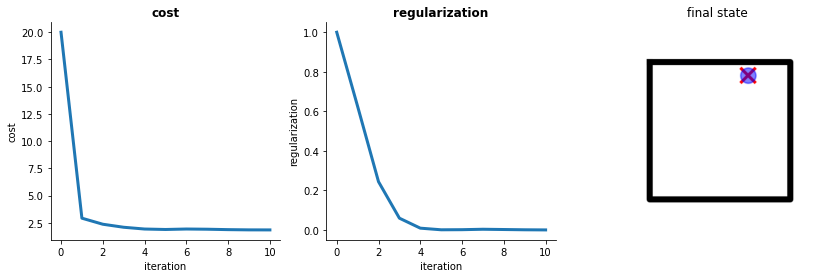

In [2]:
# run ilqr
actions, history = iLQR(env, iterations=10, verbose=True)
plot_training(env, actions, history)

The cost is reduced quite a bit. Per the Levenberg-Marquardt heuristic the regularization decreases as well. Notice how the change in cost after each iteration (the `dcost` column) is fairly close the the change in cost we expectedn based on the quadratic approximation (the `expected` column). This means our approximation of the cost was accurate for this task. Looking at a rollout reveals nice behavior:

In [3]:
show_rollout(env, actions)

### playing with cost function
The cost in the task is [a combination of distance to target at each step and the norm of the control input](https://github.com/richard-warren/rl_sandbox/blob/20b0512748516a1651c6cbe3d8d1cd013d9f1ee7/ilqr/envs.py#L146). By increasing the weight on the control input we can find policies that conserve more energy.

In [4]:
env.control_wgt = 1  # set high control weight
actions_new, history = iLQR(env, iterations=10, verbose=True)

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     1/10   4.687168    -1.53e+01   -1.54e+01   6.25e-01    decreased   0.266356    
     2/10   4.639872    -4.73e-02   -5.04e-02   2.44e-01    decreased   0.279729    
     3/10   4.631200    -8.67e-03   -1.10e-02   5.96e-02    decreased   0.270388    
     4/10   4.649280    +1.81e-02   -1.16e-02   9.54e-02    increased   0.270388    
     5/10   4.635960    +4.76e-03   -8.87e-03   2.44e-01    increased   0.270388    
     6/10   4.629282    -1.92e-03   -5.14e-03   1.53e-01    decreased   0.289437    
     7/10   4.639210    +9.93e-03   -1.02e-02   2.44e-01    increased   0.289437    
     8/10   4.630480    +1.20e-03   -6.88e-03   6.25e-01    increased   0.289437    
     9/10   4.627431    -1.85e-03   -3.16e-03   3.91e-01    decreased   0.279942    
    10/10   4.626735    -6.96e-04   -1.18e-03   1.53e-01    decr

In [5]:
show_rollout(env, actions_new)

Notice that the movements are much slower. There is no friction in this environment, so any force applied early will need to be counteracted later on. This encourages small amplitude movements. We can see this directly by plotting the controls for the small and large control cost optimizations.

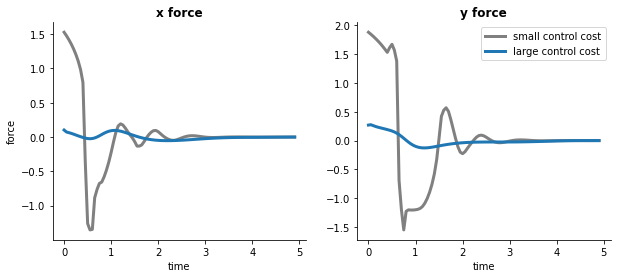

In [6]:
ax = plt.subplots(1,2, figsize=(10,4))[1]
t = np.arange(0, env.dt*env.max_steps, env.dt)
for i, label in enumerate(['x', 'y']):
    ax[i].plot(t, np.array(actions)[:,i], color='gray', label='small control cost', linewidth=3)
    ax[i].plot(t, np.array(actions_new)[:,i], color='tab:blue', label='large control cost', linewidth=3)
    ax[i].set_title(f'{label} force', fontweight='bold')
    ax[i].set_xlabel('time')
    if i==0: ax[i].set_ylabel('force')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    if i==1: ax[i].legend()

### point mass - avoiding lava
Let's make things more interesting by giving the agent competing incentives. I'm going to add a "lava field" - additional cost will accrue based on varying lava levels in the plane (bright colors = more lava).

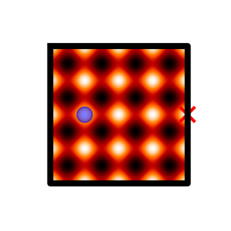

In [7]:
# make point-mass with a lava field
# the `field_wgt` argument sets the cost associated with lava
env = PointMass(field_wgt=2e-1, initial_state=(-.25,0,0,0))
env.target = np.array((.5,0))
env.show()

Notice that a direct path to the target will take the agent through high lava levels. Below the agent learns a less direct, but lower cost route. I found two tricks helped in making this work:
1. Rather than initializing the actions with all zeros, each action was uniformly sampled on the interval $(-1,1)$ (by settings`inital_action=0` below). This helped the agent "discover" superior indirect routes.
2. Setting $\alpha=.5$ helped regularize things further (see implementation notes above).

Also, notice in the video below that the agent doesn't land precisely on the target, but gets as close as possible while remaining in the safe areas of the field

In [8]:
# run ilqr and
actions, history = iLQR(env, iterations=20, initial_action=1, alpha=5e-1, verbose=True)
show_rollout(env, actions)

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     1/20   42.265073   -6.41e+01   -4.70e+01   6.25e-01    decreased   1.005581    
     2/20   22.259945   -2.00e+01   -1.61e+01   2.44e-01    decreased   1.014210    
     3/20   17.499525   -4.76e+00   -6.06e+00   5.96e-02    decreased   1.121079    
     4/20   16.572391   -9.27e-01   -6.85e-01   9.09e-03    decreased   1.449170    
     5/20   15.465738   -1.11e+00   -9.82e-01   8.67e-04    decreased   5.134190    
     6/20   14.792786   -6.73e-01   -2.76e-01   5.17e-05    decreased   5.041658    
     7/20   27.016721   +1.22e+01   -1.08e+00   8.27e-05    increased   5.041658    
     8/20   18.018388   +3.23e+00   -1.03e+00   2.12e-04    increased   5.041658    
     9/20   16.816998   +2.02e+00   -9.49e-01   8.67e-04    increased   5.041658    
    10/20   15.174215   +3.81e-01   -8.56e-01   5.68e-03    incr

### point mass - `dm_control`
The rest of the experiments use the `dm_control suite`. I built wrappers around the different evironments so I could engineer the cost functions more easily. For example, by replacing the sparse reward in the point-mass environment with squared distance to target we can use iLQR to find good polices. I also decreased the control timestep for some tasks to speed things up.

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     1/10   0.452991    -5.76e-02   -5.71e-02   6.25e-01    decreased   0.058642    
     2/10   0.383058    -6.99e-02   -7.02e-02   2.44e-01    decreased   0.139619    
     3/10   0.286581    -9.65e-02   -1.00e-01   5.96e-02    decreased   0.284921    
     4/10   0.193584    -9.30e-02   -1.05e-01   9.09e-03    decreased   0.561266    
     5/10   0.154917    -3.87e-02   -5.44e-02   8.67e-04    decreased   1.105863    
     6/10   0.150966    -3.95e-03   -1.09e-02   5.17e-05    decreased   1.592062    
     7/10   0.159958    +8.99e-03   -2.24e-03   8.27e-05    increased   1.592062    
     8/10   0.156102    +5.14e-03   -2.12e-03   2.12e-04    increased   1.592062    
     9/10   0.151427    +4.61e-04   -1.70e-03   8.67e-04    increased   1.592062    
    10/10   0.150306    -6.60e-04   -8.46e-04   5.42e-04    decr

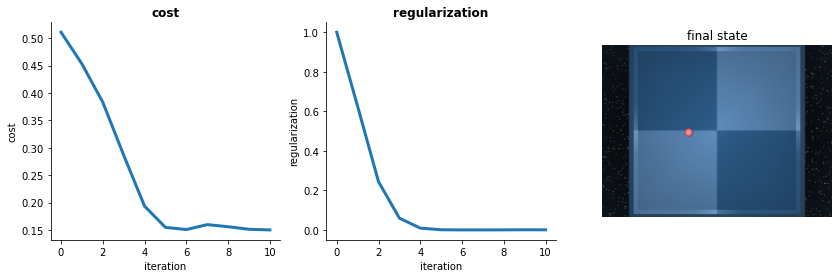

In [9]:
env = PointMassDm()
actions, history = iLQR(env, iterations=10, verbose=True)
plot_training(env, actions, history)

In [10]:
show_rollout(env, actions)

## two link arm
The reacher (two link arm) task is much more fun. The cost is again squared distance to target plus a small control cost. iLQR finds nice looking policies:

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     1/10   8.281756    -6.58e-02   -6.48e-02   8.39e+01    decreased   0.005748    
     2/10   8.140740    -1.41e-01   -1.39e-01   3.28e+01    decreased   0.016545    
     3/10   7.216773    -9.24e-01   -9.34e-01   8.00e+00    decreased   0.070667    
     4/10   2.421962    -4.79e+00   -4.10e+01   8.00e+00    decreased   1.100974    
     5/10   2.186961    -2.35e-01   -2.36e-01   3.13e+00    decreased   1.100848    
     6/10   1.750570    -4.36e-01   -5.36e-01   7.63e-01    decreased   1.103113    
     7/10   1.610461    -1.40e-01   -1.48e-01   1.16e-01    decreased   1.118097    
     8/10   1.443656    -1.67e-01   -2.15e-01   1.11e-02    decreased   1.184577    
     9/10   1.374050    -6.96e-02   -1.51e-01   6.62e-04    decreased   1.901062    
    10/10   1.370655    -3.40e-03   -8.88e-03   2.47e-05    decr

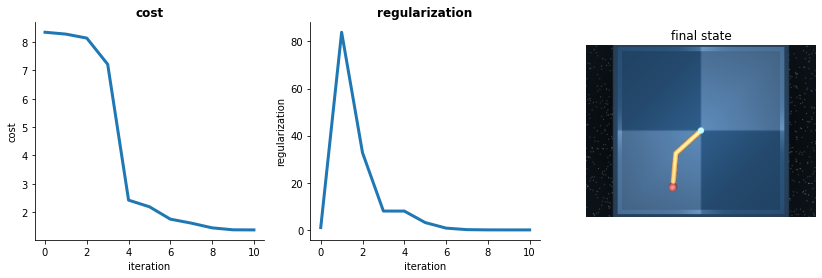

In [11]:
env = Arm(target_start=np.array((-.1,-.2)))  # make sure target is far away
actions, history = iLQR(env, iterations=10, verbose=True)
plot_training(env, actions, history)

In [12]:
show_rollout(env, actions)

### two link arm - moving target
Now I'll make the target move in a spiral pattern. The time horizon is also longer (200 vs. 40 steps). Nonetheless iLQR finds a policy that accurately tracks the target.

In [13]:
env = Arm(spiral=.02, target_start=np.array((.1,.1)))
actions, history = iLQR(env, iterations=10, verbose=True)
show_rollout(env, actions)

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     1/10   3.490992    -2.70e+00   -2.82e+00   8.39e+01    decreased   0.010291    
     2/10   2.720523    -7.70e-01   -7.71e-01   3.28e+01    decreased   0.020800    
     3/10   2.050617    -6.70e-01   -4.56e+00   8.00e+00    decreased   0.142981    
     4/10   1.307606    -7.43e-01   -3.46e-01   1.22e+00    decreased   0.162490    
     5/10   0.697209    -6.10e-01   -5.98e-01   1.16e-01    decreased   0.253781    
     6/10   0.354112    -3.43e-01   -4.40e-01   6.94e-03    decreased   0.814950    
     7/10   0.149900    -2.04e-01   -2.36e-01   2.58e-04    decreased   1.378877    
     8/10   0.146899    -3.00e-03   -3.52e-02   6.02e-06    decreased   3.331029    
     9/10   0.340603    +1.94e-01   -1.12e+00   6.94e-03    increased   3.331029    
    10/10   0.132887    -1.40e-02   -2.26e-02   4.34e-03    decr

Plotting the end effector position on top of the target position shows that the tracking was quite successful.

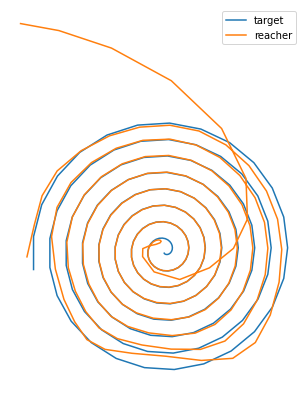

In [14]:
# record end effector and target position throughout episode
env.reset(reset_target=False)
target_pos, arm_pos = [], []
for action in actions:
    env.step(action)
    arm_pos.append(env.env.physics.named.data.geom_xpos['finger', :2].copy())
    target_pos.append(env.target)

# plot
plt.figure(figsize=(7,7));
ax = plt.axes()
ax.plot(np.array(target_pos)[:,0], np.array(target_pos)[:,1], label='target');
ax.plot(np.array(arm_pos)[:,0], np.array(arm_pos)[:,1], label='reacher');
ax.set_aspect('equal');
ax.axis('off');
plt.legend();

## hopper
The hopper has 14 degrees of freedom and can be actuated at four points. The dynamics are far more complex than the previous tasks. Here I use iLQR to find a "standing" policy. The cost function is the negative of the torso height. With no actions the agent quickly falls over:

In [15]:
# see what happens with no actions
env = Hopper()
actions = [np.repeat(0, env.action_dim) for i in range(env.max_steps)]
show_rollout(env, actions)

Now we'll find a policy that allows the hopper to stand upright.

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     1/10   56.204892   -4.47e-01   -9.08e+00   8.39e+01    decreased   0.068827    
     2/10   44.716334   -1.15e+01   -7.67e+00   3.28e+01    decreased   0.049264    
     3/10   28.794451   -1.59e+01   -6.79e+00   8.00e+00    decreased   0.122459    
     4/10   27.984000   -8.10e-01   -1.15e+00   1.22e+00    decreased   0.203373    
     5/10   27.269455   -7.15e-01   -5.94e-01   1.16e-01    decreased   0.153996    
     6/10   27.194249   -7.52e-02   -1.17e-01   6.94e-03    decreased   0.231838    
     7/10   27.139865   -5.44e-02   -6.76e-02   2.58e-04    decreased   0.753283    
     8/10   27.288032   +1.48e-01   -1.27e-02   4.14e-04    increased   0.753283    
     9/10   27.159966   +2.01e-02   -1.11e-02   1.06e-03    increased   0.753283    
    10/10   27.141331   +1.47e-03   -7.84e-03   4.34e-03    incr

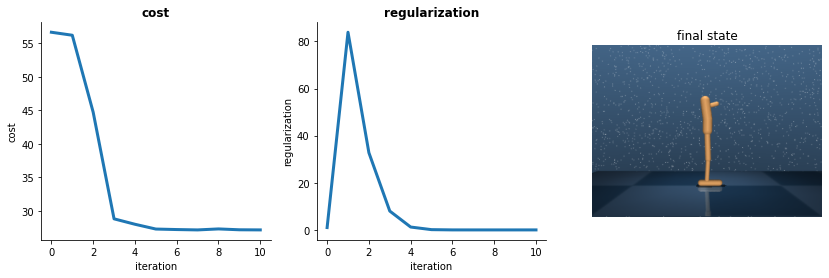

In [16]:
# run ilqr
env = Hopper(control_wgt=1e-3)
actions, history = iLQR(env, iterations=10, verbose=True)
plot_training(env, actions, history)

In [17]:
show_rollout(env, actions)

Although this behavior appears simple, it is made possible by a relatively nuanced control sequence. Notice the stabilizing kick in the middle of the control sequence $(t \approx .5)$.

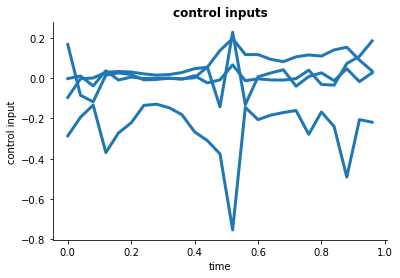

In [18]:
t = np.arange(0, env.dt*env.max_steps, env.dt)
ax = plt.axes(xlabel='time', ylabel='control input');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.plot(t, actions, color='tab:blue', linewidth=3);
ax.set_title('control inputs', fontweight='bold');

# todo
- iLQR worked well for simple tasks, but for hopper it only worked with a relatively short time horizon of 25 steps. Things diverged for longer horizons. Potential fixes:
    - Dynamically setting $\alpha$ with a proper line search algorithm may help.
    - Long behaviors may be better handled with online trajectory optimization, e.g. at each time point optimize $n$ time points into the future, advance $m<n$ steps, then re-optimize... That is the general approach Yuval took in [this](https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf) paper, and the resultant behaviors are super impressive.
    - I suspect there may be numerical errors that compound for longer horizons in the hopper environment. In my finite differences computation I use [a relatively large $\epsilon$](https://github.com/richard-warren/rl_sandbox/blob/20b0512748516a1651c6cbe3d8d1cd013d9f1ee7/ilqr/envs.py#L87) - things diverge otherwise (only for this task). I should explore whether gradients are trending towards zero over the course of the backward pass... 
- I should speed things up by parallelizing the gradient computation across multiple CPU cores.













































